# __Categorize a continuous variable__
> * Here is a quick and scalable way to categorize a continuous variable into different levels.  
> * We use a method called **continuous-mean** to find the cut points by input column. There's no need to use hardcode settings.
> * The process is data-driven and easy to apply. However, domain experts must still review and revise the naive results if necessary.

<iframe src="https://docs.google.com/presentation/d/1hJ02ZPlP4rY62HzJrLNIDnwAWSWaeTxbuwerU2kwr-8/embed?start=false&slide=1＆loop=false&delayms=3000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>

## Import sample data
Data source: Kaggle, https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business/data


In [7]:
import polars as pl
import seaborn as sb
import matplotlib.pyplot as plt

agg_uid = pl.read_csv("../data_source/kaggle_data/Sales_Transaction_v4a/agg_uid.csv", try_parse_dates = True)
agg_uid.select('cust_id', 'n_days').rename({"n_days": "number-of-active-days"})

cust_id,number-of-active-days
i64,i64
15421,3
12534,1
14739,8
12789,1
14215,6
…,…
12436,1
14877,1
16532,3


## Quick Check
We've aggregated the total number of active days by each member. The distribution is right-skew. Over **75%** of members' active days are under **4** days, and many members just purchase **1** to **2** times. This is a classic scenario when we analyze customer behavior data.

In [8]:
agg_uid.select('n_days').rename({"n_days": "number-of-active-days"}).describe()

statistic,number-of-active-days
str,f64
"""count""",4718.0
"""null_count""",0.0
"""mean""",3.826621
"""std""",5.752403
"""min""",1.0
"""25%""",1.0
"""50%""",2.0
"""75%""",4.0
"""max""",130.0


Text(0.5, 0, 'number-of-active-days')

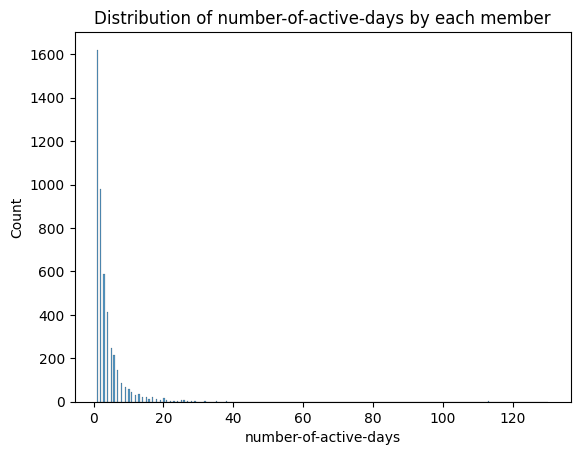

In [9]:
g = sb.histplot(data = agg_uid, x = "n_days")
g.set_title("Distribution of number-of-active-days by each member")
g.set_xlabel("number-of-active-days")

## Process of Continuous-Mean 

### Intuitive way

In [10]:
x = agg_uid.select('n_days').to_series()

m1 = x.mean()
m2 = x.filter(x > m1).mean()
m3 = x.filter(x > m2).mean()

y = (
    pl.Series(['L'] * len(x))
    .set(x > m1, 'M')
    .set(x > m2, 'H')
    .set(x > m3, 'T')
)

cate_enum = pl.Enum(['T', 'H', 'M', 'L'])
y = pl.Series(y, dtype = cate_enum)
y.value_counts().sort(by = "")

,count
enum,u32
"""T""",122
"""H""",296
"""M""",1109
"""L""",3191


### Create a general function
Users can set how many groups they want and the Enum list.

In [11]:
def continuous_mean_grouping(x: pl.Series, n_group: int, high_to_low_name: list[str] = None) -> pl.Series:
    
    if high_to_low_name is not None and len(high_to_low_name) != n_group:
        raise ValueError("The length of high_to_low_name must be equal to n_group!")
        
    N = n_group    
    m0 = x.min() - 1
    
    if high_to_low_name is None:
        names = [j+1 for j in range(N)]
        y = pl.Series([N] * len(x))
    elif high_to_low_name is not None: 
        names = high_to_low_name
        y = pl.Series([names[-1]] * len(x))
    
    for i in range(N-1):
        m1 = x.filter(x > m0).mean()
        y = y.set(x > m1, names[-i-2])
        m0 = m1

    if high_to_low_name is not None: 
        cate_enum = pl.Enum(names)
        return pl.Series(y, dtype = cate_enum)
    else:
        return y


agg_uid = (
    agg_uid
    .with_columns(
        thml_n_days = pl.col('n_days').map_batches(lambda x: continuous_mean_grouping(x, n_group = 4, high_to_low_name = ['T', 'H', 'M', 'L']))
    )
)

agg_uid.select('cust_id', 'n_days', 'thml_n_days').sample(n = 10)

cust_id,n_days,thml_n_days
i64,i64,enum
12725,1,"""L"""
15460,1,"""L"""
16065,1,"""L"""
16212,2,"""L"""
16730,3,"""L"""
14348,1,"""L"""
14112,5,"""M"""
12897,2,"""L"""
15224,2,"""L"""


## Application

### Check the grouping boundary and member count.
It can help us identify or highlight the heavy users.

In [20]:
(
    agg_uid
    .group_by('thml_n_days')
    .agg(
        min_v = pl.col('n_days').min(),
        max_v = pl.col('n_days').max(),
        mean_v = pl.col('n_days').mean().round(2),
        people = pl.len()
    )
    .sort(by = 'thml_n_days')
)

thml_n_days,min_v,max_v,mean_v,people
enum,i64,i64,f64,u32
"""T""",17,130,28.07,122
"""H""",9,16,11.41,296
"""M""",4,8,5.32,1109
"""L""",1,3,1.68,3191


### Cross other dimension
It can help us find more insights about the members.

In [23]:
main_data = pl.read_csv('../data_source/kaggle_data/Sales_Transaction_v4a/main.csv', try_parse_dates = True)

In [24]:
(
    main_data
    .join(
        
    )
)

txn_id,txndate,pid,pname,price,quantity,cust_id,country,payment
i64,date,str,str,f64,i64,i64,str,f64
581482,2019-12-09,"""22485""","""Set Of 2 Wooden Market Crates""",21.47,12,17490,"""United Kingdom""",257.64
581475,2019-12-09,"""22596""","""Christmas Star Wish List Chalk…",10.65,36,13069,"""United Kingdom""",383.4
581475,2019-12-09,"""23235""","""Storage Tin Vintage Leaf""",11.53,12,13069,"""United Kingdom""",138.36
581475,2019-12-09,"""23272""","""Tree T-Light Holder Willie Win…",10.65,12,13069,"""United Kingdom""",127.8
581475,2019-12-09,"""23239""","""Set Of 4 Knick Knack Tins Popp…",11.94,6,13069,"""United Kingdom""",71.64
…,…,…,…,…,…,…,…,…
536585,2018-12-01,"""37449""","""Ceramic Cake Stand + Hanging C…",20.45,2,17460,"""United Kingdom""",40.9
536590,2018-12-01,"""22776""","""Sweetheart 3 Tier Cake Stand""",20.45,1,13065,"""United Kingdom""",20.45
536590,2018-12-01,"""22622""","""Box Of Vintage Alphabet Blocks""",20.45,2,13065,"""United Kingdom""",40.9


In [ ]:
# def transform_THML(x: pl.Series) -> pl.Series:
#     m1 = x.mean()
#     m2 = x.filter(x > m1).mean()
#     m3 = x.filter(x > m2).mean()

#     y = (
#         pl.Series(['L'] * len(x))
#         .set(x > m1, 'M')
#         .set(x > m2, 'H')
#         .set(x > m3, 'T')
#     )
    
#     cate_enum = pl.Enum(['T', 'H', 'M', 'L'])
#     z = pl.Series(y, dtype = cate_enum)
    
#     return z

# (
#     agg_uid
#     .with_columns(
#         thml_n_days = pl.col('n_days').map_batches(transform_THML)
#     )
#     .group_by('thml_n_days')
#     .agg(
#         min_v = pl.col('n_days').min(),
#         max_v = pl.col('n_days').max(),
#         n = pl.len()
#     )
#     .sort(by = 'thml_n_days')
# )

In [60]:
# N = 4
# names = [j+1 for j in range(N)]
# # names.reverse()
# print(
#     names,
#     names[-4],
#     sep = "\n"
# )

# high_to_low_name = ['T', 'H', 'M', 'L']
# high_to_low_name.reverse()
# high_to_low_name.reverse()
# high_to_low_name

[1, 2, 3, 4]
1


['T', 'H', 'M', 'L']

In [56]:
# xx = agg_uid.select('n_days').to_series()
# y = pl.Series([names[0]] * len(xx))


# N: int = 4

# yy = xx.clone()
# m0 = yy.min() - 1

# z = pl.Series([N] * len(xx))
# avg_list = list()
# for i in range(N-1):
#     m1 = yy.filter(yy > m0).mean()
#     z = z.set(xx > m1, (N - i - 1))
#     m0 = m1
#     avg_list.append(m1)
    
    
# # z = pl.Series([N] * len(xx))
# # for i in range(N-1):
# #     z = z.set(xx > avg_list[i], (N - i - 1))


# print(
#     avg_list,
#     z,
#     sep = "\n"
# )



<iframe src="https://docs.google.com/presentation/d/1hJ02ZPlP4rY62HzJrLNIDnwAWSWaeTxbuwerU2kwr-8/embed?start=false&loop=false&slide=6&rm=minimal" width="960" height="569" allowfullscreen="true"></iframe>